<a href="https://colab.research.google.com/github/Kcnarf/spamDetectionWithML/blob/master/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import files
uploaded = files.upload()

Saving spamham_meetic_en_custcare_messages_vsc_training-data_30_11_2020.csv to spamham_meetic_en_custcare_messages_vsc_training-data_30_11_2020.csv


In [6]:
import io
# data = pd.read_csv('SMSSpamCollection.csv',encoding = 'utf8', sep='\t', header=None, names=["v1", "v2"])
data = pd.read_csv('spamham_vsc_training.csv',encoding = 'utf8', sep=';', header=None, names=["v1", "v2"])

In [7]:
data.head()

,v1,v2
0,Spam,"Hi customercare@help.affiny.co.uk, We will he..."
1,Spam,96 ...
2,Spam,My phone says that you are 3 km away. I'm Wid...
3,Spam,"Elizbeth Smith, Thank you for contacting us. ..."
4,Spam,96 ...


In [8]:
data["text"] = data.v2
data["spam"] = data.v1

# Splitting data

In [9]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2) 

In [10]:
data.info

<bound method DataFrame.info of         v1  ...  spam
0     Spam  ...  Spam
1     Spam  ...  Spam
2     Spam  ...  Spam
3     Spam  ...  Spam
4     Spam  ...  Spam
...    ...  ...   ...
1660   Ham  ...   Ham
1661   Ham  ...   Ham
1662   Ham  ...   Ham
1663   Ham  ...   Ham
1664   Ham  ...   Ham

[1665 rows x 4 columns]>

In [11]:
emails_train.shape

(1332,)

# Preprocessing

In [12]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'shared a file with you                                      hi its private love ️  no fake only for real come night friends  for many scams we decided to a launch  safescam free craigslist personal section like site for dating only  we already have  active female members from your state  live chat now   join with us and chathook up with our female membersim here   sent from my iphone                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [14]:
train_y

array([1, 0, 1, ..., 0, 1, 0])

# Tokenize

In [15]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [16]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


[102,
 18,
 159,
 26,
 2,
 93,
 268,
 388,
 269,
 598,
 113,
 450,
 169,
 8,
 239,
 250,
 225,
 497,
 8,
 204,
 474,
 16,
 415,
 1,
 18,
 498,
 475,
 221,
 342,
 96,
 273,
 152,
 163,
 8,
 253,
 169,
 16,
 232,
 25,
 274,
 227,
 223,
 9,
 10,
 254,
 303,
 212,
 173,
 270,
 26,
 17,
 5,
 499,
 164,
 26,
 46,
 227,
 500,
 162,
 43,
 9,
 11,
 191,
 549,
 4,
 114,
 40,
 125,
 8,
 156,
 72,
 72,
 74,
 157]

# Padding

In [17]:
from keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ...,  72,  74, 157], dtype=int32)

# Model

In [18]:
import tensorflow as tf

# were you lucky today?
!nvidia-smi -L

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.device('/device:GPU:0')

GPU 0: Tesla K80 (UUID: GPU-3aab564e-5b9a-d06b-fbd4-8c9787df7488)
Found GPU at: /device:GPU:0


In [31]:
# create the model
from keras.layers import Bidirectional, Dense, Input, LSTM, Embedding, Dropout, Activation

embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


# Training

Epoch 1/20
6/6 [==============================] - 8s 769ms/step - loss: 0.6861 - accuracy: 0.5586 - val_loss: 0.6736 - val_accuracy: 0.5796
Epoch 2/20
6/6 [==============================] - 3s 564ms/step - loss: 0.6700 - accuracy: 0.5646 - val_loss: 0.6469 - val_accuracy: 0.5796
Epoch 3/20
6/6 [==============================] - 3s 561ms/step - loss: 0.6307 - accuracy: 0.5661 - val_loss: 0.5639 - val_accuracy: 0.7387
Epoch 4/20
6/6 [==============================] - 3s 564ms/step - loss: 0.5449 - accuracy: 0.7995 - val_loss: 0.4587 - val_accuracy: 0.8228
Epoch 5/20
6/6 [==============================] - 3s 558ms/step - loss: 0.4467 - accuracy: 0.8529 - val_loss: 0.3557 - val_accuracy: 0.9219
Epoch 6/20
6/6 [==============================] - 3s 564ms/step - loss: 0.2998 - accuracy: 0.9129 - val_loss: 0.2197 - val_accuracy: 0.9640
Epoch 7/20
6/6 [==============================] - 3s 561ms/step - loss: 0.2005 - accuracy: 0.9550 - val_loss: 0.1400 - val_accuracy: 0.9640
Epoch 8/20
6/6 [====

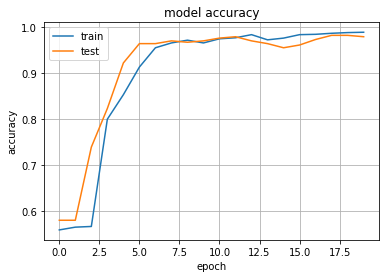

In [32]:
history = model.fit(x_train_features, train_y, batch_size=256, epochs=20, validation_data=(x_test_features, test_y))

from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Evaluation

Precision: 98.54%
Recall: 96.43%
F1 Score: 97.47%


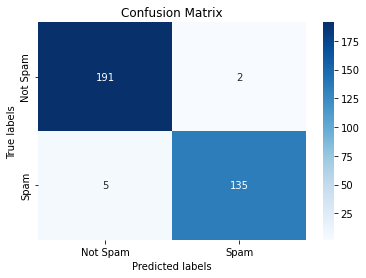

In [33]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns
import matplotlib.pyplot as plt

y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

cf_matrix =confusion_matrix(test_y,y_predict)

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);